# Assignment 2: Text Classification with Convolutional Neural Networks

**Description:** This assignment covers various neural network architectures and components, largely used in the context of classification. You will compare Deep Averaging Networks, Convolutional Neural Networks, and BERT-based models. In part two, you should be able to develop an intuition for:


*   The effects of fine-tuning word vectors and over fitting the model
*   How various hyperparameters can help or hurt overfitting




The assignment notebook closely follows the lesson notebooks. We will use the IMDB dataset and will leverage some of the models, or part of the code, for our current investigation.

This notebook uses the Keras 3 functional API.  Make sure the correct versions get loaded.




## IMPORTANT NOTE:
Because of the environment built in to Colab, the software we're importing causes an error to be thrown the first time you run the cells in the Setup section.  As soon as you hit the error, you have to go to the Runtime menu and select 'Restart Session'.  Once the session is restarted you must rerun the cells in Setup and you will not run in to the error.

<a id = 'returnToTop'></a>

## Notebook Contents
  * 1. [Setup](#setup)
  * 2. [Creation of the Dataset](#creationOfDataset)  
  * 3. [Modeling](#modeling)
    * 3.1 [Fix Convolutional Neural Net (CNN) Over Fitting](#modelCNN)


  
  
  [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/datasci-w266/2025-summer-main/blob/master/assignment/a2/Text_classification_CNN.ipynb)

[Return to Top](#returnToTop)  
<a id = 'setup'></a>
## 1. Setup

This notebook requires the tensorflow dataset and other prerequisites that you must download and then store locally in your Colab environment.


In [ ]:
!pip install numpy==1.26.4 --quiet
!pip install scipy==1.13.0 --quiet
!pip install gensim --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 36.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.4 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow-datasets --quiet

In [ ]:
!pip install -U tensorflow-text --quiet

In [ ]:
!pip install pydot --quiet

Ready to do the imports.

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"


import numpy as np
import tensorflow as tf
import keras

from keras.layers import Embedding, Input, Dense, Lambda
from keras.models import Model
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re


import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

Below is a helper function to plot histories.

In [ ]:
# 4-window plot of loss and accuracy for two models, for comparison

def make_plot(axs,
              model_history1,
              model_history2,
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[metric])
            ax1.plot(model_history.history['val_%s' % metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

Next, we get the word2vec model from nltk.

In [ ]:
nltk.download('word2vec_sample')

In [ ]:
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))

In [ ]:
vec_model = KeyedVectors.load_word2vec_format(datapath(word2vec_sample), binary=False)

We can now build the embedding matrix and a vocabulary dictionary:

In [ ]:
EMBEDDING_DIM = len(vec_model['university'])      # we know... it's 300

# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(vec_model) + 1, EMBEDDING_DIM))
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(vec_model.index_to_key):
    embedding_vector = vec_model[word]

    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

# we can use the last index at the end of the vocab for unknown tokens
vocab_dict['[UNK]'] = len(vocab_dict)

In [ ]:
embedding_matrix.shape

[Return to Top](#returnToTop)  
<a id = 'creationOfDataset'></a>
## 2. Creation of the Dataset

### 2.1 Data Acquisition

We will use the IMDB dataset delivered as part of the tensorflow-datasets library, and split into training and test sets. For expedience, we will limit ourselves in terms of train and test examples.

In [ ]:
train_data, test_data = tfds.load(
    name="imdb_reviews",
    split=('train[:80%]', 'test[80%:]'),
    as_supervised=True)

In [ ]:
train_examples, train_labels = next(iter(train_data.batch(20000)))
test_examples, test_labels = next(iter(test_data.batch(5000)))

In [ ]:
train_examples[:4]

In [ ]:
train_labels[:4]

Next, we tokenize the data:

In [ ]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_examples)
test_tokens = tokenizer.tokenize(test_examples)

Does this look right?

In [ ]:
train_tokens[0]

Yup... looks right. Of course we will need to take care of the encoding later.

### 2.2 Data Preparation

For the models we will use, we need to define a maximum sequence length (max number of tokens per movie review that we'll feed into our model). We'll cut off any tokens longer than that, and we'll pad shorter movie reviews with zeros at the end.

In [ ]:
MAX_SEQUENCE_LENGTH = 128

Next, we define a simple function that converts the tokens of each movie review into their word2vec vocabulary index values.   

In [ ]:
def docs_to_vocab_ids(tokenized_texts_list):
    """
    converting a list of strings to a list of lists of word ids
    """
    texts_vocab_ids = []
    for i, token_list in enumerate(tokenized_texts_list):

        # Get the vocab id for each token in this doc ([UNK] if not in vocab)
        vocab_ids = []
        for token in list(token_list.numpy()):
            decoded = token.decode('utf-8', errors='ignore')
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])

        # Truncate text to max length, add padding up to max length
        vocab_ids = vocab_ids[:MAX_SEQUENCE_LENGTH]
        n_padding = (MAX_SEQUENCE_LENGTH - len(vocab_ids))
        # For simplicity in this model, we'll just pad with uknown tokens
        vocab_ids += [vocab_dict['[UNK]']] * n_padding

        # Add this example to the list of converted docs
        texts_vocab_ids.append(vocab_ids)

        if i % 5000 == 0:
            print('Examples processed: ', i)

    print('Total examples: ', i)

    return np.array(texts_vocab_ids)

Now we can create training and test data that can be fed into the models of interest.

In [ ]:
train_input = docs_to_vocab_ids(train_tokens)
test_input = docs_to_vocab_ids(test_tokens)

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

Let's convince ourselves that the data looks correct.  We expect the train data to be an array of integer ids and the labels to be an array of zeroes and ones (since we are learning a binary classifier).

In [ ]:
train_input[:2]

In [ ]:
train_labels[:4]

[Return to Top](#returnToTop)  
<a id = 'modeling'></a>
## 3. Modeling




<a id = 'modelCNN'></a>
### 3.1 CNN Model

Next let's build a CNN model. We'll also wrap the model building code in a function that takes some hyperparameters, so that we can adjust things like number of filters and filter sizes later.

In [ ]:
def build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    cnn_input_layer = keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    cnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    cnn_embeddings = cnn_embedding_layer(cnn_input_layer)

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(cnn_embeddings)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)

    conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(conv_output)

    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)

    cnn_prediction = keras.layers.Dense(1, activation='sigmoid')(last_hidden_output)

    cnn_model = keras.Model(inputs=cnn_input_layer, outputs=cnn_prediction)
    cnn_model.compile(optimizer='adam',
                      loss='binary_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return cnn_model

In [ ]:
# Now specify model hyperparameters and call the function to create a CNN model

num_filters = [100, 100, 50, 25]
kernel_sizes = [3, 4, 5, 10]
dense_layer_dims = [100, 50]
dropout_rate = 0.5

cnn_model = build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate)

In [ ]:
cnn_model.summary()

The keras plot utility shows this probably a bit nicer:

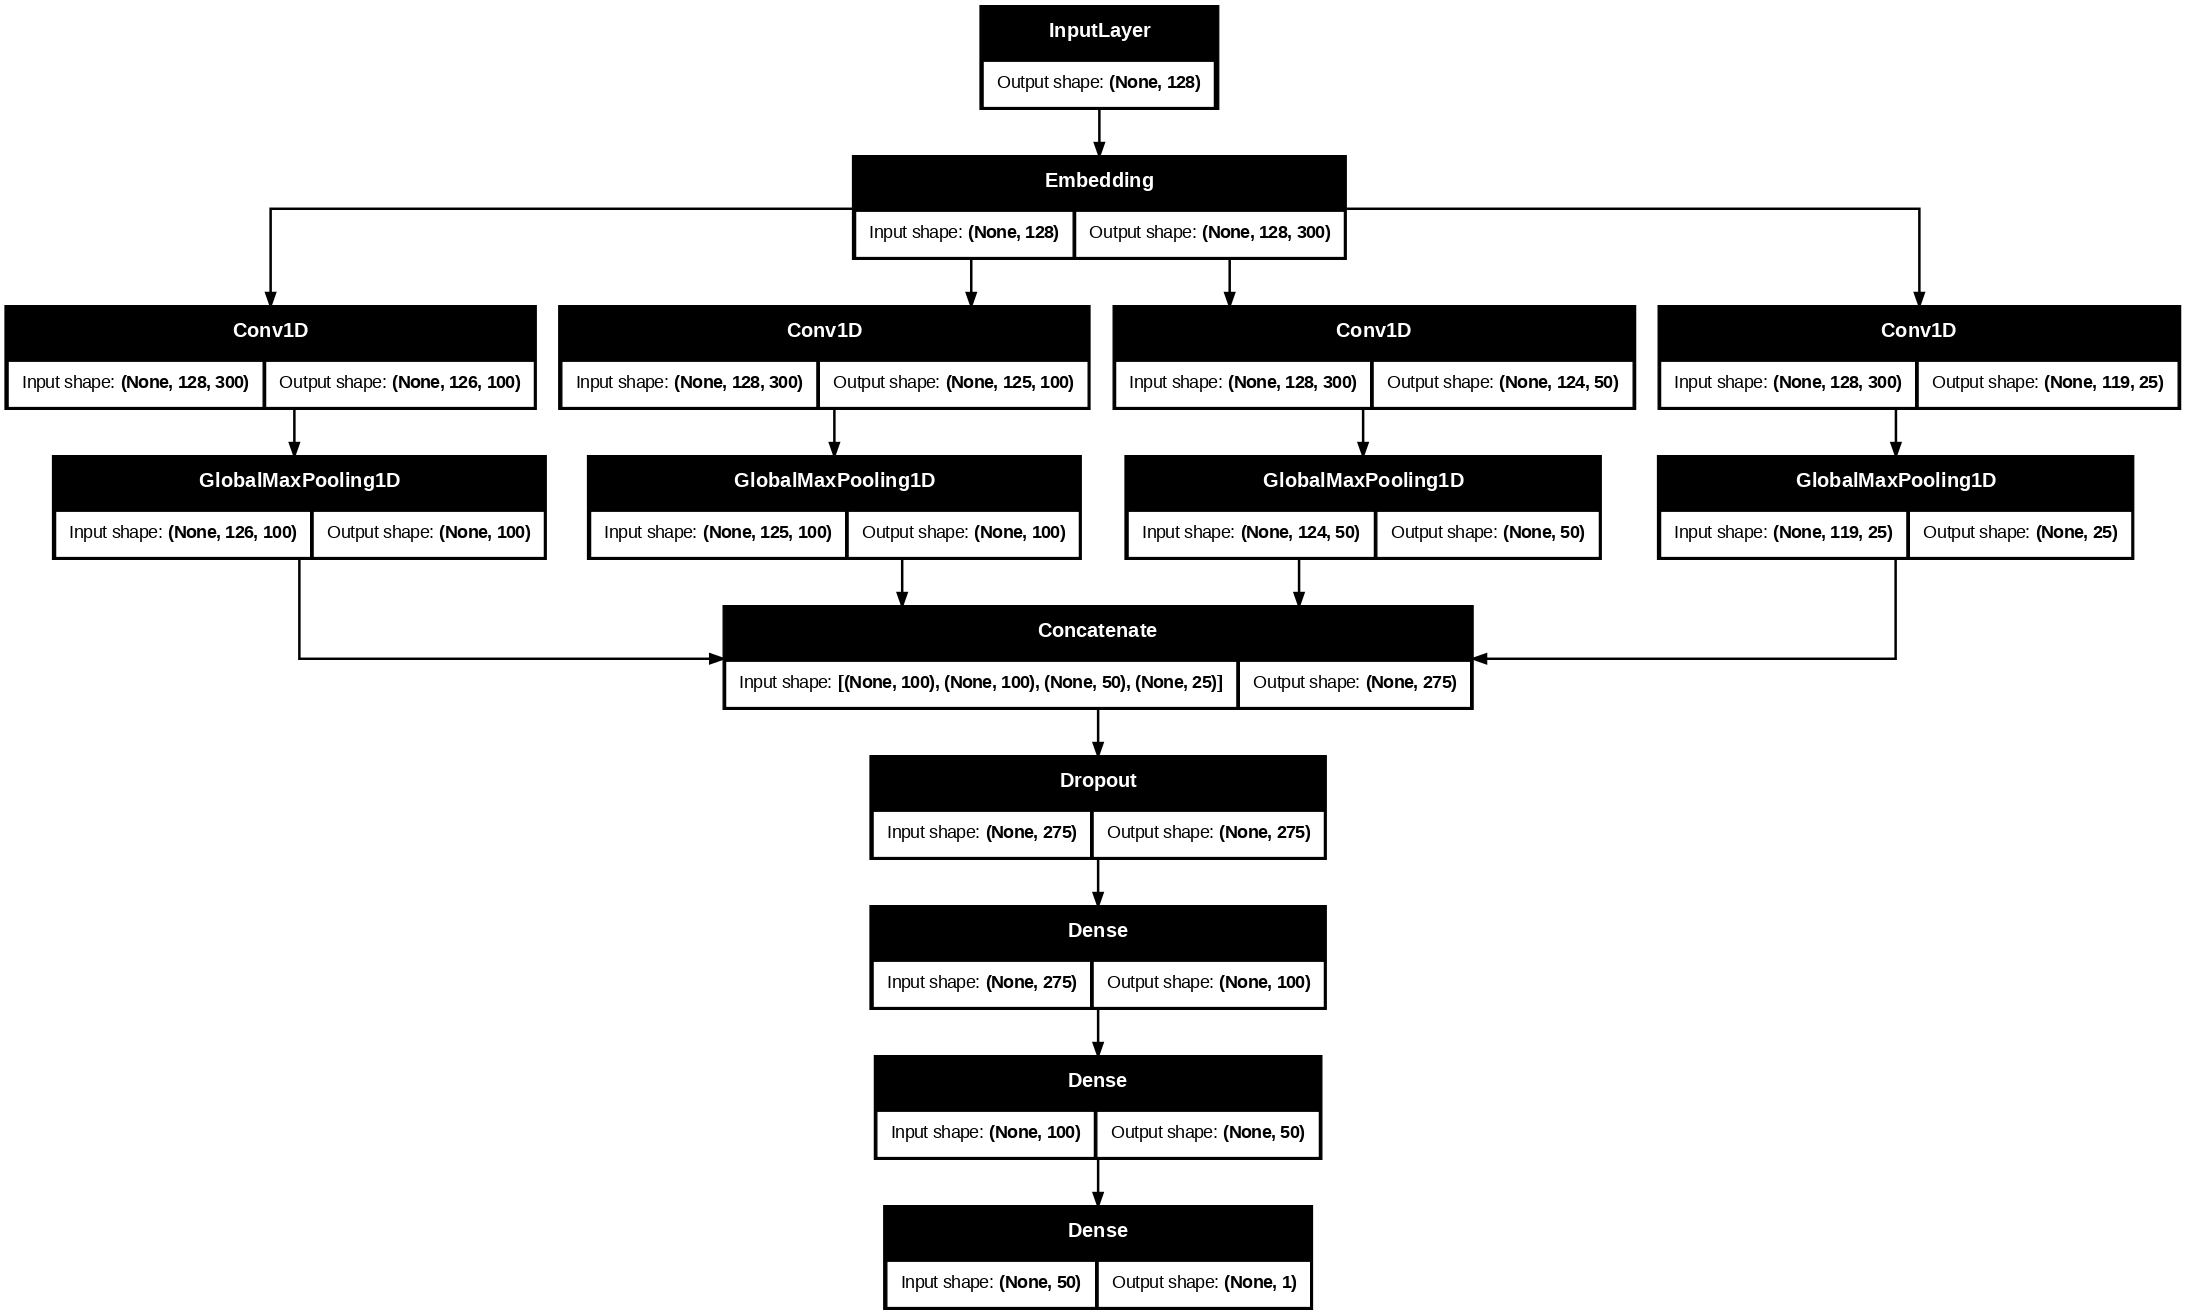

In [ ]:
keras.utils.plot_model(cnn_model, show_shapes=True, dpi=90)

Now let's train our CNN and see if it can learn without overfitting or underfitting.

In [ ]:
cnn_history = cnn_model.fit(train_input,
                            train_labels,
                            validation_data=(test_input, test_labels),
                            batch_size=32,
                            epochs=5
                            )

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 132s 206ms/step - accuracy: 0.6181 - loss: 0.6249 - val_accuracy: 0.7982 - val_loss: 0.4339
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 140s 203ms/step - accuracy: 0.7987 - loss: 0.4291 - val_accuracy: 0.8136 - val_loss: 0.4062
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 132s 186ms/step - accuracy: 0.8324 - loss: 0.3715 - val_accuracy: 0.8178 - val_loss: 0.3964
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 152s 203ms/step - accuracy: 0.8665 - loss: 0.3136 - val_accuracy: 0.8134 - val_loss: 0.4097
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 143s 204ms/step - accuracy: 0.8923 - loss: 0.2625 - val_accuracy: 0.8098 - val_loss: 0.4089


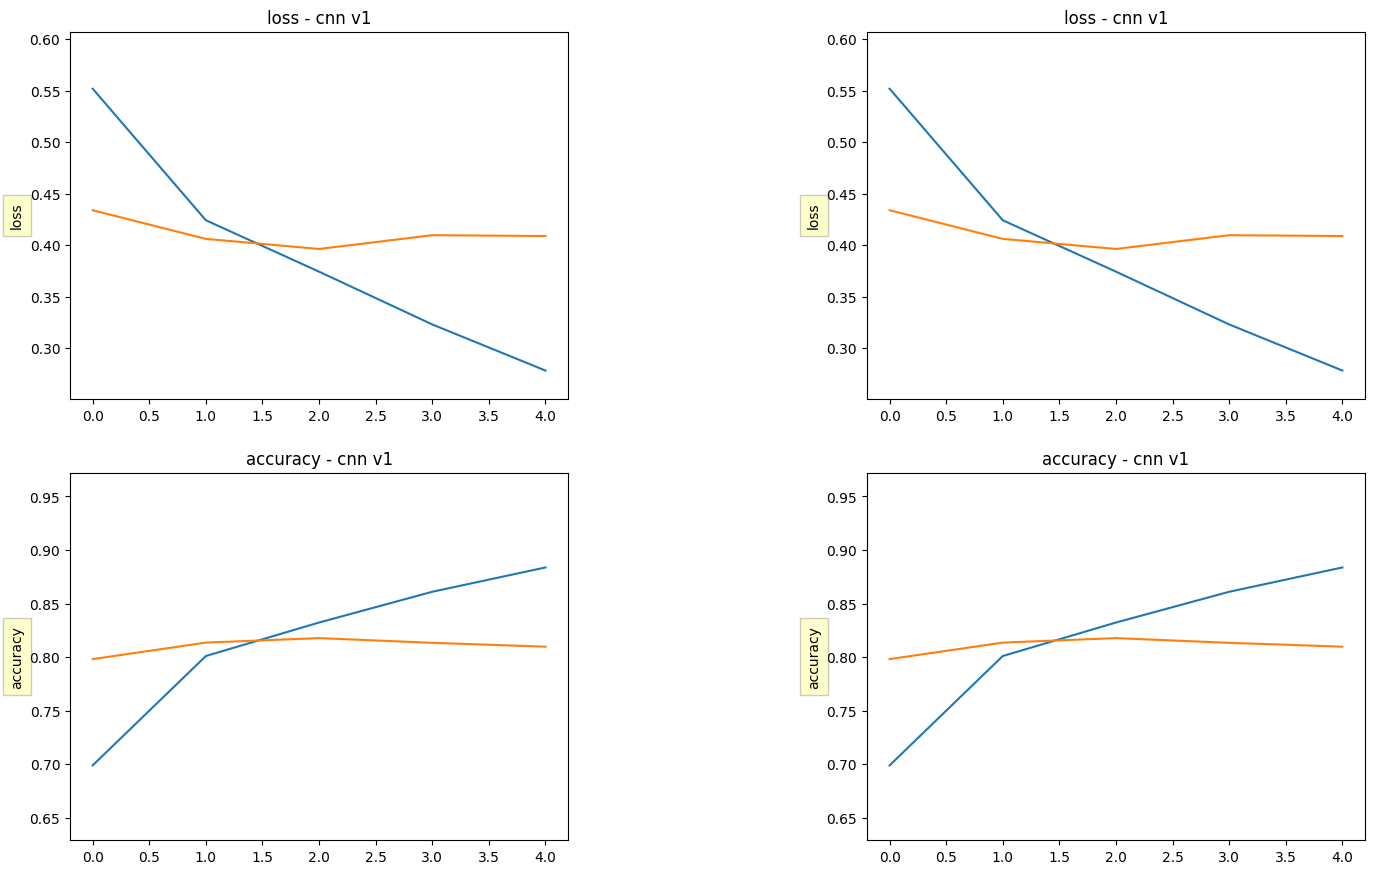

In [ ]:
# Do the plots change how you'd expect?
# Did the runtime change (in the cells above)?

fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          cnn_history,
          cnn_history,
          model_1_name='cnn v1',
          model_2_name='cnn v1')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

[Return to Top](#returnToTop)  
<a id = 'cnnExercise'></a>
### 3.2. CNN Exercise

A. The CNN model above is overfitting.  You can tell this because the training loss keeps going down while the validation loss is increasing. Can you make the CNN model overfit less? What parameter(s) might you change to make this model less likely to overfit? How good (or bad) can you make it get?

> Hint: think about all of the options you can vary, including:
* add/remove more hidden layers
* vary dropout rates and dimensions
* enable/disable retraining of embedding matrix
* change number of filters
* change kernel sizes of filters
* change the batch size
>
> For the option(s) you choose, do you think it will make the model more or less likely to overfit? Try it, does it work the way you expect?

Here is an example of the loss curve for a model that is extremely overfit:

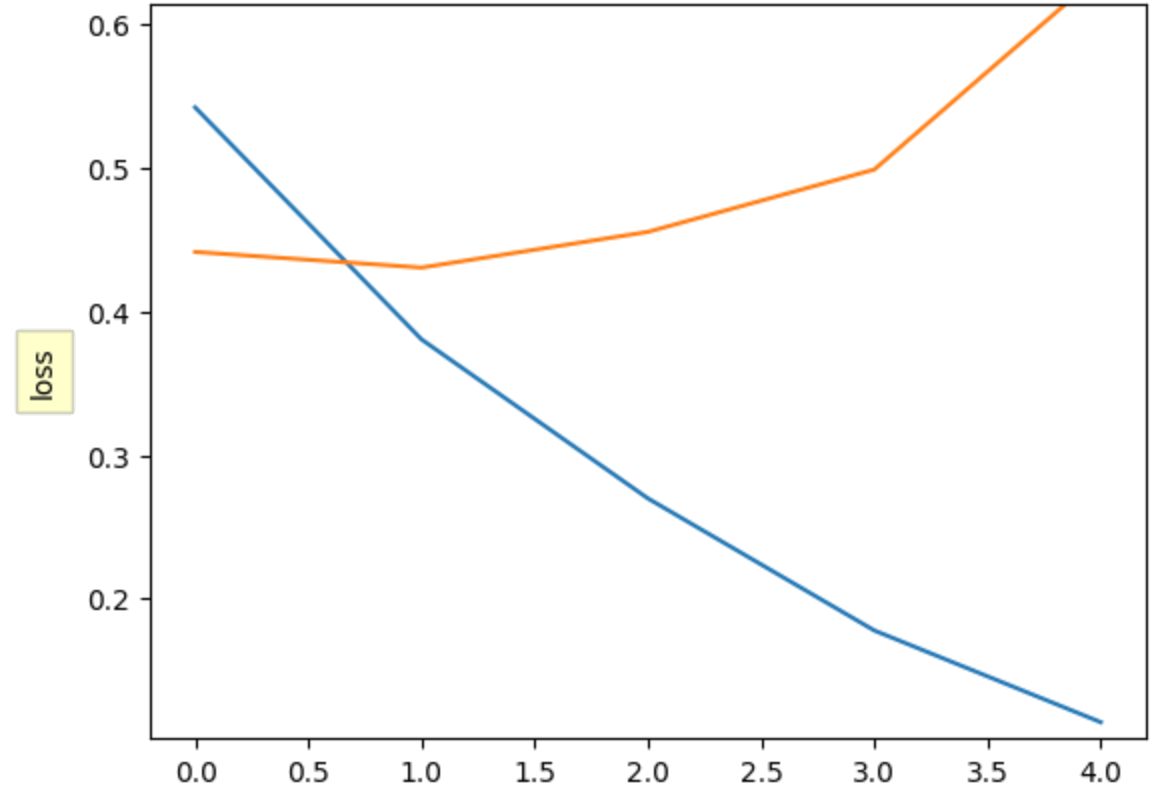

and here is an example of the loss curve where the model is converging and not overfitting:

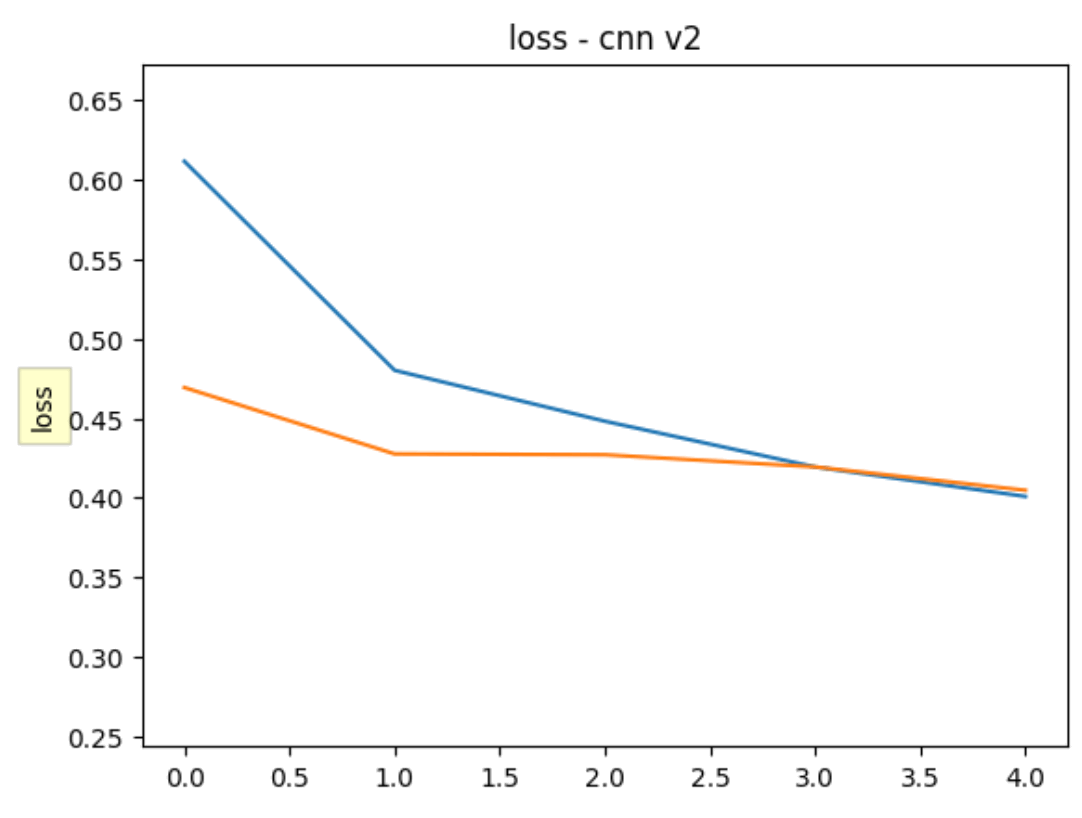


Your task is to fix the CNN model so that it is no longer overfit when you train it.  You should modify the specified hyperparameters until the model no longer overfits. We define your goal as a case where after each epoch, the loss and val_loss value is lower than the epoch before.  This will be reflected in the shape of the loss curves as shown above.  

In [ ]:
# CNN model hyperparameters: Change these

### YOUR CODE HERE

num_filters = [64, 64]  # Fewer filters = less model complexity
kernel_sizes = [3, 5]   # Smaller kernels help generalize better
dense_layer_dims = [64] # Fewer dense layers and units
dropout_rate = 0.6      # More dropout to regularize the model
embeddings_trainable = False  # Keep embeddings fixed to avoid overfitting
batch_size = 64         # Slightly larger batch size can help smooth updates

### END YOUR CODE

cnn_model2 = build_cnn_model(num_filters, kernel_sizes, dense_layer_dims,
                            dropout_rate, embeddings_trainable)

cnn_history2 = cnn_model2.fit(train_input,
                              train_labels,
                              validation_data=(test_input, test_labels),
                              batch_size=batch_size,
                              epochs=5
                              )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 48s 145ms/step - accuracy: 0.5756 - loss: 0.6638 - val_accuracy: 0.7818 - val_loss: 0.4653
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 146ms/step - accuracy: 0.7676 - loss: 0.4856 - val_accuracy: 0.7932 - val_loss: 0.4362
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 141ms/step - accuracy: 0.8043 - loss: 0.4293 - val_accuracy: 0.8130 - val_loss: 0.4161
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 142ms/step - accuracy: 0.8195 - loss: 0.3943 - val_accuracy: 0.8074 - val_loss: 0.4215
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 141ms/step - accuracy: 0.8400 - loss: 0.3639 - val_accuracy: 0.8160 - val_loss: 0.4030


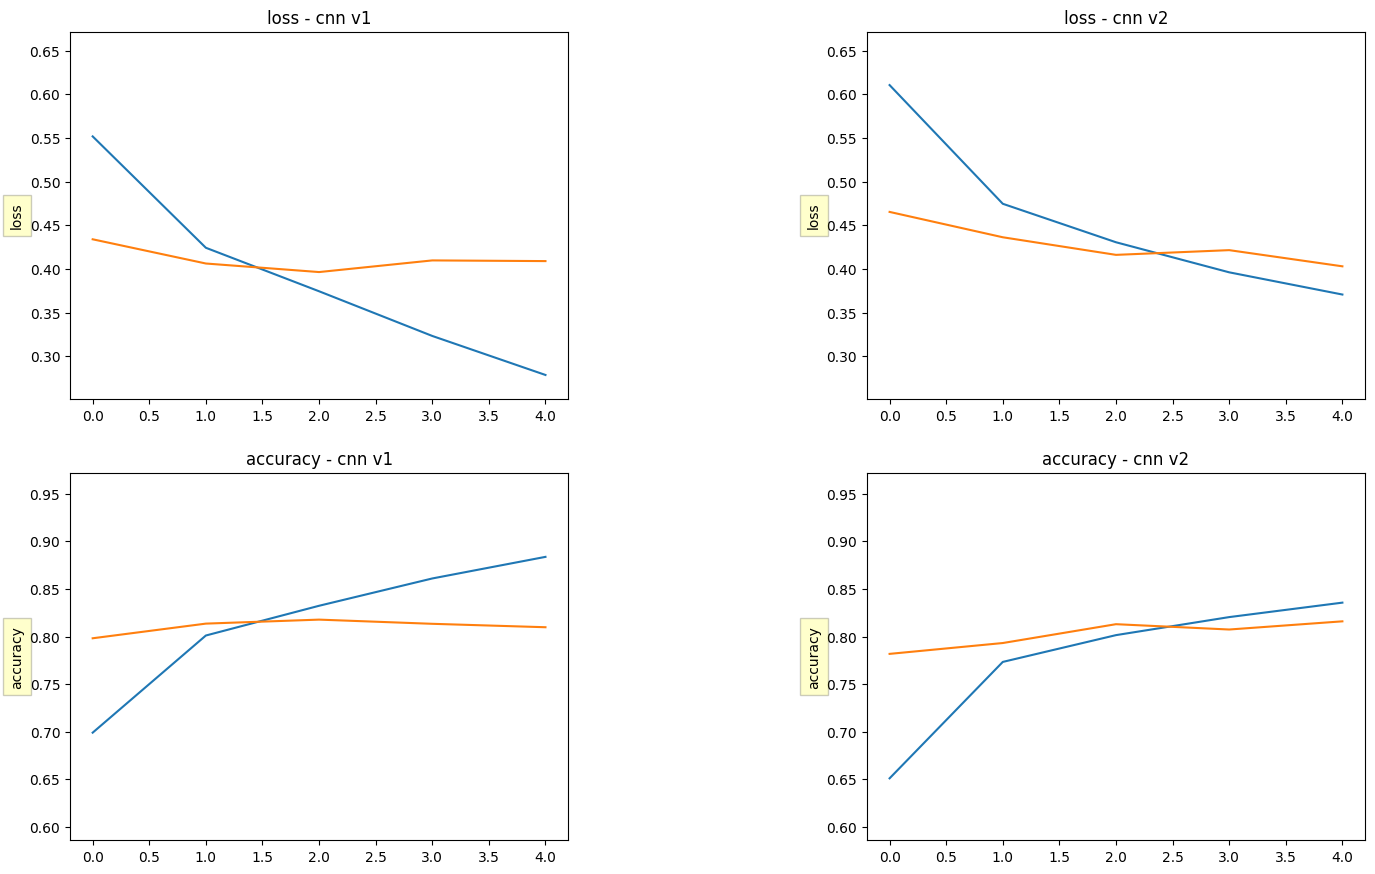

In [ ]:
# Do the plots change how you'd expect?
## Yes, the plots changed in a way that shows less overfitting in cnn v2 compared to cnn v1.
## In cnn v1, training loss decreases steadily, but validation loss flattens and then slightly increases — a classic sign of overfitting.
## In cnn v2, both training and validation loss decrease more smoothly across epochs, and validation accuracy slightly improves — indicating better generalization.

# Did the runtime change (in the cells above)?
## Yes, the runtime decreased slightly. This is expected — smaller models tend to train quicker and generalize better, especially when overfitting is a concern.

fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          cnn_history,
          cnn_history2,
          model_1_name='cnn v1',
          model_2_name='cnn v2')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

 **QUESTION:**

1.a
What is the val_loss value you have after the 1st epoch of training?  Copy the value in the output to the answers file.

 **QUESTION:**

1.b
What is the val_loss value you have after the 2nd epoch of training?  Copy the value in the output to the answers file.

 **QUESTION:**

1.c
What is the val_loss value you have after the 3rd epoch of training?  Copy the value in the output to the answers file.


 **QUESTION:**

1.d
What is the val_loss value you have after the 4th epoch of training?  Copy the value in the output to the answers file.

 **QUESTION:**

1.e
What is the val_loss value you have after the 5th and final epoch of training.  Copy the value in the output to the answers file.


 **QUESTION:**

1.f
What values did you use for num_filters = [] to stop the overfitting? Copy the values into the answers file.


 **QUESTION:**

1.g
What values did you use for kernel_sizes = [] to stop the overfitting? Copy the values into the answers file.


 **QUESTION:**

1.h
What values did you use for dense__layer_dims= [] to stop the overfitting? Copy the values into the answers file.


 **QUESTION:**

1.i
What value did you use for dropout_rate = [] to stop the overfitting? Copy the value into the answers file.


 **QUESTION:**

1.j
What value did you use for embeddings_trainable = to stop the overfitting? Copy the value into the answers file.


 **QUESTION:**

1.k
What value did you use for batch_size = to stop the overfitting? Copy the value into the answers file.

You're done with this portion.  Continue on to the next notebook.